COMP 215 - LAB 6 (Game of Life)
-----------------------------------------------
#### Name:
#### Date:

This lab exercise is an introduction to [Conway's Game of Life](https://en.wikipedia.org/wiki/Conway%27s_Game_of_Life) discovered and studied by [John Conway](https://en.wikipedia.org/wiki/John_Horton_Conway).

**New Python concepts**:
   * 2D numpy [array](https://numpy.org/doc/stable/reference/generated/numpy.array.html)
   * basic [array operations](https://www.pluralsight.com/guides/overview-basic-numpy-operations)

**New Computation concepts**:
   * [2D sliding dot product](https://docs.scipy.org/doc/scipy/reference/generated/scipy.signal.correlate2d.html)
   * [Animation](https://matplotlib.org/stable/api/animation_api.html)

**Credits**:
    Code examples based on [Think Complexity, 2nd edition](https://thinkcomplex.com).
    Copyright 2016 Allen Downey, [MIT License](http://opensource.org/licenses/MIT)

As usual, the first code cell simply imports all the modules we'll be using...

In [1]:
import time
import matplotlib
import matplotlib.pyplot as plt
from matplotlib import animation
import numpy as np
from scipy.signal import correlate2d
import random

%matplotlib inline
# Configure matplotlib's animation library to work in the browser.
matplotlib.rc('animation', html='jshtml')

A reusable function for plotting 2D numpy.array as an image...

In [2]:
def plot_2d_array(array, axes=None, title='', cmap='Blues', **options):
    """
    Plot the 2D array as an image on the given axes  1's will be dark blue, 0's will be light blue.

    :param axes: the axes to plot on, or None to use the `plt.gca()` (current axes)
    :param options: keyword arguments passed directly to `plt.imshow()`
           see https://matplotlib.org/stable/api/_as_gen/matplotlib.axes.Axes.imshow.html
    """
    axes = axes or plt.gca()  # If not axes are provided, draw on current axes
    axes.set_title(title)
    # Turn off axes labels and tick marks
    axes.tick_params(axis='both', which='both', bottom=False, top=False, left=False, right=False ,
                     labelbottom=False, labeltop=False, labelleft=False, labelright=False,)
    # Defaults for displaying a "matrix" with hard-pixel boundaries and (0,0) at top-left
    options = {**dict(interpolation='nearest', origin='upper'), **options}
    axes.imshow(array, cmap=cmap, **options)

## Life Fundamentals
Both the textbook and our week6 notebooks develop some fundamental operations for simulating the Game of Life.
Some of the code from `week6.ipynb` is reproduced here without deriving all the ideas - review `week6.ipynb` notebook for the full story.
The sliding dot product algorithm in `step` is implemented with [scipy.signal.correlate2d](https://docs.scipy.org/doc/scipy/reference/generated/scipy.signal.correlate2d.html).  It's behaviour is identical to the derivation in `week6.ipynb`.

#### Notes
* we use `correlate2d(state, kernel, mode='same', boundary='wrap')` to pad state matrix with 1 value around perimeter from the opposite side of the matrix.
* since the rule is a 1D `np.array`, we use "vector indexing" here to set the 'live' state transitions:  `next_state[[3, 12, 13]] = 1`

In [3]:
class Life2D:
    """ An basic 2D Cellular Automata that implementes Conway's Game of Life """
    kernel = np.array([[1, 1, 1],
                       [1, 10, 1],
                       [1, 1, 1]])

    next_state = np.zeros(19, dtype=np.uint8)
    next_state[[3, 12, 13]] = 1

    def __init__(self, n_rows, n_cols=None):
        """ Construct a n_rows x n_cols 2D CA """
        n_cols = n_cols or n_rows  # i.e., n_cols if n_cols is not None and n_cols != 0 else n_rows
        self.state = np.zeros(shape=(n_rows, n_cols), dtype=np.uint8)

    def step(self):
        """Executes one time step. """
        transitions = correlate2d(self.state, self.kernel, mode='same', boundary='wrap')
        self.state = self.next_state[transitions]

    def draw(self, axes=None, step=''):
        axes = axes or plt.gca()   # use pyplot's current axes if none are provided.
        plot_2d_array(self.state, axes, title=f"Conway's Game of Life {step}")

### Visualizing a 2D simulation model
For 1D CAs, we could use a 2D image to visualize the CA progression over time.
For 2D CAs, we could try using time as a 3rd axis to generate a 3D visualziation, but without VR, its hard to explore a 3D visualization.
Instead, we'll use a simple 2D ["stop motion" animation](https://en.wikipedia.org/wiki/Animation).
Here is a generic class that animates any 2D model that provides step() and draw() methods, and uses matplotlib to render its state.

See [Matplotlib animation in Jupyter](https://www.allendowney.com/blog/2019/07/25/matplotlib-animation-in-jupyter/) by our textbook author for a discussion of the pros and cons of various animation techniques in jupyter notebooks.

In [4]:
class Animation2D:
    """
      Animates any 2D model with a step() method and a draw() method, using matplotlib
      model.step() should take no parameters - just step the model forward one step.
      model.draw() should take 2 parameters, the matpltolib axes to draw on and an integer step number
    """

    def __init__(self, model, frames=50, figsize=(8, 8)):
        """
        :param model: the simulation object to animate, with step() and draw(axes, step) methods
        :param frames: number of animation frames to generate
        """
        self.model = model
        self.frames = frames
        self.fig, self.ax = plt.subplots(figsize=figsize)

    def animation_step(self, step):
        """ Step the model forward and draw the plot """
        if step > 0:
            self.model.step()
        self.model.draw(self.ax, step=step)

    def show(self):
        """ return the matplotlib animation object, ready for display """
        anim = animation.FuncAnimation(self.fig, self.animation_step, frames=self.frames)
        plt.close()  # this ensures the last frame is not shown as a separate plot
        return anim

    def animate(self, interval=None):
        """ Animate the model simulation directly in the notebook display block """
        from IPython.display import clear_output
        try:
            for i in range(self.frames):
                clear_output(wait=True)  # clear the IPython display
                self.ax.clear()          # clear old image from the axes (fixes a performance issue)
                plt.figure(self.fig)     # add the figure back to pyplot ** sigh **
                self.animation_step(i)
                plt.show()               # show the current animation frame (pyplot then closes and throws away figure ** sigh **)
                if interval:
                    time.sleep(interval)
        except KeyboardInterrupt:
            pass

### Sample usage
Animate a single glider...

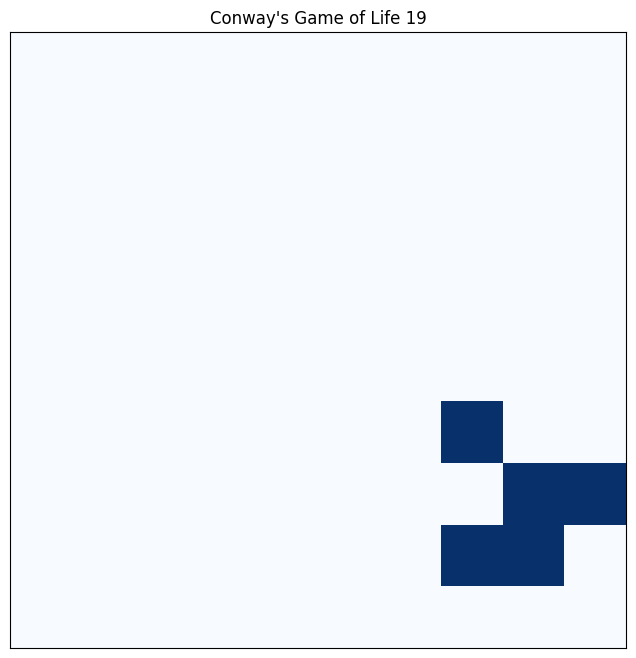

In [61]:
size = 10
life = Life2D(size)
glider = np.array([[0, 1, 0], [0, 0, 1], [1, 1, 1]], dtype=np.uint8)
life.state[1:4, 2:5] = glider             # bad idea to alter an objects state directly!  We'll improve it in Ex. 3
gol = Animation2D(life, frames=20)
gol.animate()

## Exercise 1:  Enumerate all Elementary 2D CA's
Write a line or 2 of code to compute and print the answer for each question:
* how many unique states are there for a 3x3 (9 cell) neighbourhood?
* how many unique “rules” are there? (where a rule provides a mapping for each possible neighbourhood state to the output for the centre cell)
* how does this number compare, for example, to the [number of atoms in the observable universe?](https://en.wikipedia.org/wiki/Observable_universe#Matter_content%E2%80%94number_of_atoms)

In [6]:
# Ex. 1 your code here...
unique_states = 2**9
unique_rules = 2**unique_states
atoms_in_universe = 10**78

print(unique_states)
print(unique_rules)
print(atoms_in_universe)
print(f"2^512 is {unique_rules/atoms_in_universe} times bigger than the number of atoms in the universe")


512
13407807929942597099574024998205846127479365820592393377723561443721764030073546976801874298166903427690031858186486050853753882811946569946433649006084096
1000000000000000000000000000000000000000000000000000000000000000000000000000000
2^512 is 1.3407807929942597e+76 times bigger than the number of atoms in the universe


Using what you learned above, concisely answer each question below (point form)1
1. would it be a reasonable goal to conduct an experiment like Wolfram’s for 2D CA’s?
2. propose a numbering scheme for these rules, analogous to Wolfram’s rule numbers
3. how might we go about determining which rule number corresponds to Conway’s GoL?
   (I’m not asking for the number, but rather for a method you could use to find it.)

#### Ex 1. Your Answers

1. No, the number of rules is so large, we definitely cant look at them all in a lifetime, let alone before the heat death of the universe.
2. Number each of the 512 states and make a 512 digit binary number where the indexes correspond to each state's indexes where each digit represents the output from that state.
3. Find all the states where the cell is alive in the next step, and using the numbered order of the states, find the 512 digit binary number where the index of those states have the value 1 and every other digit is 0.

## Exercise 2: random_life
Extend the Life2D class defined above to allow the game to be initialized with a random start state.
The liklihood of any given cell being initialized to "alive" is given by $p$.
*Hint*: we did this exact exercise for a 1D array in previous lab

In [15]:
# Ex. 2 experimental setup

class BetterLife2D(Life2D):
    """ Improvements on the basic Life2D model """

    def randomize_state(self, p):
        """ Randomize the state of this GoL, where probability of a "live" cell is p """
        n_rows = self.state.shape[0]
        n_cols = self.state.shape[1]
        self.state = np.array([[1 if random.random() < p else 0 for item in range(n_cols)] for item in range(n_rows)])

    def load_pattern(self,x,y,pattern):
      self.state[x:x + pattern.shape[0] , y:y + pattern.shape[1]] = pattern



# ------------------------- END OF CLASS METHODS

def random_life(n_rows, n_cols=None, p=0.5):
    """ Return a Life2D object of given dimensions with initial randomized state where "live" cells have probability p """
    life_obj = BetterLife2D(n_rows,n_cols)
    life_obj.randomize_state(p)
    return life_obj


a = BetterLife2D(8,6)
print(f'BetterLife2D object "a"\n{a.state}')
a.randomize_state(.9)
print(f'\nRandomized state of "a"\n{a.state}')
print(f'\n Random life func test\n{random_life(5,3).state}')


BetterLife2D object "a"
[[0 0 0 0 0 0]
 [0 0 0 0 0 0]
 [0 0 0 0 0 0]
 [0 0 0 0 0 0]
 [0 0 0 0 0 0]
 [0 0 0 0 0 0]
 [0 0 0 0 0 0]
 [0 0 0 0 0 0]]

Randomized state of "a"
[[1 1 1 1 1 1]
 [1 1 1 1 1 1]
 [1 1 1 1 0 0]
 [1 0 1 1 1 0]
 [1 1 1 1 1 1]
 [1 1 1 0 1 1]
 [1 1 1 1 1 1]
 [1 1 1 1 1 1]]

 Random life func test
[[1 1 1]
 [1 0 1]
 [0 1 0]
 [1 1 1]
 [1 1 0]]


### Experiment
Run a small experiment to see if you can identify any relationship between $p$, the probability of a live cell in the initial grid, and the time it takes for the GoL pattern to stabilize.

I noticed that for a 10 by 10 block it took:
* p > .7 | under 10 steps
* p = .6 | around 10-20 steps
* p = .5 | mostly around 20-50 steps but lots of variety, some very small, others over 100
* p = .4 | mostly around 30-50 steps but lots of variety too, most often either 20-30 or 100+ steps
* p = .3 | around 10-60 steps, even more variety, there were also a slight range between 80-100 steps.
* p = .2 | under 30 steps, much less variety than 0.3 < p < 0.5 but still some took 60+.
* p < .1 | under 10 steps

This is based off of 25 trial runs each and a table I drew on my whiteboard keeping track of the amount of steps it took per run.

It seems that when p is 30%-50% the most variety happens and it takes longer to resolve. I think this may be due to a similar reason that for the 1D cellular automatas, the rules with a 50/50-ish spilt of 0s and 1s had more complex behaivour.

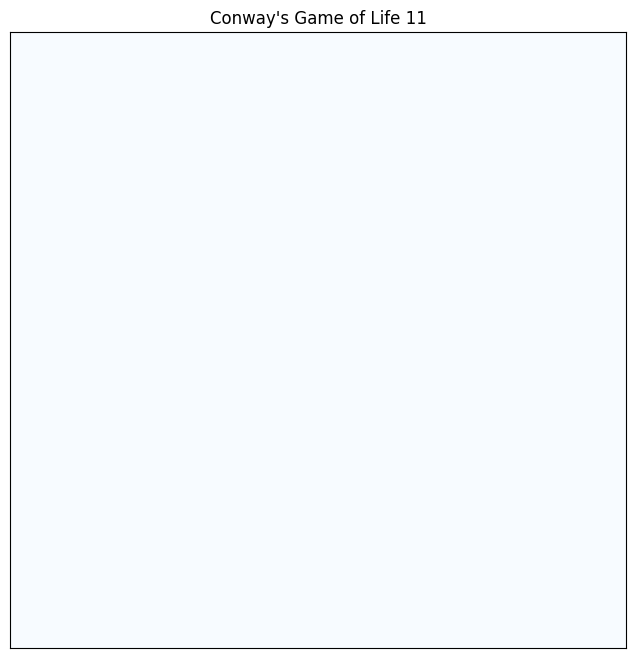

In [60]:
# Ex. 2 write code for your experiment here...
p = 0.1
life = random_life(10,p=p)
def experiment(life_obj,frames):
  gol = Animation2D(life_obj, frames=frames)
  gol.animate()

experiment(life,200)


## Exercise 3: Load Patterns
People have discovered many interesting ["patterns"](https://conwaylife.com/wiki/Category:Patterns) that exhibit various types of behaviours.
A "pattern" is just a small 2D array.
 1. Develop a function that returns a 2D array containing the patterns defined by a single string; and
 2. Add a `load_pattern(x, y, pattern)` method to your `BetterLife2D` class above to insert patterns into the Life state array
    *Tip*: you can [assign an entire 2D slice of a numpy array](https://www.nickmccullum.com/advanced-python/numpy-indexing-assignment/) in a single assignment statement!   See example in the Sample Usage block above. Try it!

In [9]:
# Here's an example of the glider pattern from above defined in a single string...
glider_pattern = \
    """
    010
    001
    111
    """

# Ex. 3 your code here...
def str_to_array(pattern_string):
  row = []
  array = []

  for char in pattern_string:
    if char in ['0','1']:
      row.append(int(char))

    if char == '\n' and row != []:
      array.append(row)
      row = []

  return np.array(array)

print(str_to_array(glider_pattern))


[[0 1 0]
 [0 0 1]
 [1 1 1]]


### Define some patterns
User your nifty new function to define a few common, interesting patterns (e.g., from the book or other sources)

In [18]:
# Ex. 3 define your patterns here...

gosper_gun_pattern = \
"""

000000000000000000000000100000000000
000000000000000000000010100000000000
000000000000110000001100000000000011
000000000001000100001100000000000011
110000000010000010001100000000000000
110000000010001011000010100000000000
000000000010000010000000100000000000
000000000001000100000000000000000000
000000000000110000000000000000000000

"""
sideways_gosper_gun_pattern = \
"""
000110000
000110000
000000000
000000000
000000000
000000000
000000000
000000000
000000000
000000000
001110000
010001000
100000100
100000100
000100000
010001000
001110000
000100000
000000000
000000000
000011100
000011100
000100010
000000000
001100011
000000000
000000000
000000000
000000000
000000000
000000000
000000000
000000000
000000000
000001100
000001100
"""

glider_pattern_dl = \
    """
    010
    001
    111
    """
glider_pattern_dr = \
    """
    010
    100
    111
    """

eater_pattern = \
"""
1100
1010
0010
0011
"""

left_glider = str_to_array(glider_pattern_dl)
right_glider = str_to_array(glider_pattern_dr)
gosper_gun = str_to_array(gosper_gun_pattern)
sideways_gosper_gun = str_to_array(sideways_gosper_gun_pattern)
eater = str_to_array(eater_pattern)


### Experiment
Load up a BetterLife2D object with some patterns that interact in some interesting way.
What can we learn from studying interactions like this?   Is anything here applicable to the real world?

Through my experiments below, I think that the gosper guns interacting have the potential to make some unique patterns and that those probably are the basis for making an actual computer using GOL.

For real world applications, you could use this or any other 2D celluar automata to model complex real problems in a simpler way. Like how game of life loosely models real life, by showing overcrowding, isolation, and stable populations working in a somewhat similar way to an ecosystem in real life.

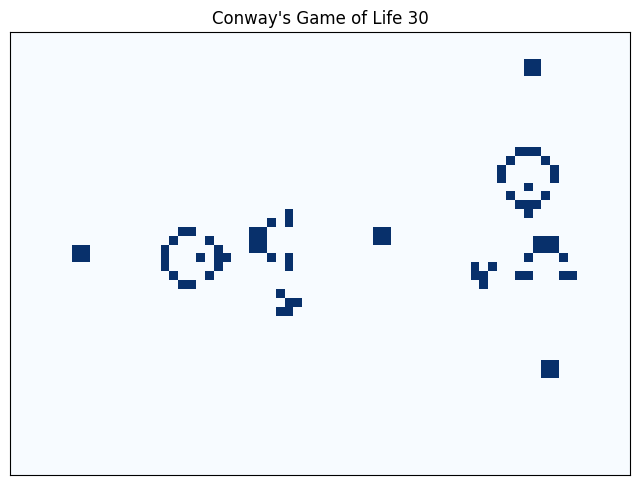

In [59]:
# I put stuff into functions so only the relevant test ran rather than all of them

def run_a():
  """ Used to try using a gosper gun and trying to figure out how to place eater """
  a = BetterLife2D(50,50)
  a.load_pattern(3,3,gosper_gun)
  a.load_pattern(26,40,eater)
  experiment(a,200)

def run_b():
  """ Used to see what happens when gliders collide from different spots """
  b = BetterLife2D(50,50)
  b.load_pattern(10,3,left_glider)
  b.load_pattern(3,55,right_glider)
  experiment(b,200)

def run_c1():
  """ Used to mess around with position of gosper guns- gliders kill each other """
  c1 = BetterLife2D(50,70)
  c1.load_pattern(20,7,gosper_gun)
  c1.load_pattern(3,55,sideways_gosper_gun)
  experiment(c1,200)

def run_c2():
  """ Used to mess around with position of gosper guns- try to make gliders pass by each other
  **Note on this below
  """
  c2 = BetterLife2D(50,70)
  c2.load_pattern(21,5,gosper_gun)
  c2.load_pattern(3,55,sideways_gosper_gun)
  experiment(c2,200)

# run_a()
# run_b()
run_c1()
# run_c2() # doesn't work :( just makes gliders go boom

  **Note about the above:
  
  After trying for a while, I noticed that its really easy to make gliders 'disappear' each other or 'explode', but when I cycled through every increment between the gliders, I couldn't get any to pass through each other.
  
  This is just anecdotal evidence but I think if you wanted to try and get them through each other you'd have to find a way to thin out the stream, either that or I'm very unlucky.

  Also unrelated but through pausing at the right times, I learned that gosper guns have a period of 30, because step 30 looked like step 0 but with 1 glider and step 90 looked the same but with 3 gliders. I probably could have googled this but where's the fun in that?